# New York City - East River Bicycle Crossings traffic predictions
1. How many bicycles cross into and out of Manhattan per day?
2. What is the top bridge in terms of bike load?
3. Which factors allow to predict daily total bike traffic volume on East River Bicycle Crossings?


In [49]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.core.dtypes.cast import maybe_infer_to_datetimelike
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline

In [13]:
april_17_f = "C:\\Users\\aekal\\Desktop\\git\\BikeTrafficPrediction\\rowery_xls\\04 April 2017 Cyclist Numbers for Web.xlsx"
may_17_f = "C:\\Users\\aekal\\Desktop\\git\\BikeTrafficPrediction\\rowery_xls\\05 May 2017 Cyclist Numbers for Web.xlsx"
june_17f = "C:\\Users\\aekal\\Desktop\\git\\BikeTrafficPrediction\\rowery_xls\\06 June 2017 Cyclist Numbers for Web.xlsx"
july_17f = "C:\\Users\\aekal\\Desktop\\git\\BikeTrafficPrediction\\rowery_xls\\07 July 2017 Cyclist Numbers for Web.xlsx"
aug_17f = "C:\\Users\\aekal\\Desktop\\git\\BikeTrafficPrediction\\rowery_xls\\08 August 2017 Cyclist Numbers for Web.xlsx"
sep_17f = "C:\\Users\\aekal\\Desktop\\git\\BikeTrafficPrediction\\rowery_xls\\09 September 2017 Cyclist Numbers for Web.xlsx"
oct_17f = "C:\\Users\\aekal\\Desktop\\git\\BikeTrafficPrediction\\rowery_xls\\10 October 2017 Cyclist Numbers.xlsx"

In [14]:
april_17 = pd.read_excel(april_17_f, skiprows=5, nrows=30, na_values="T").drop(['Unnamed: 0', 'Unnamed: 11','Day'], axis=1)

may_17 = pd.read_excel(may_17_f, skiprows=5, nrows=31, na_values="T").drop(['Unnamed: 0', 'Unnamed: 11','Day'], axis=1)

june_17 = pd.read_excel(june_17f, skiprows=5, nrows=30, na_values="T").drop(['Unnamed: 0', 'Unnamed: 11','Day'], axis=1)

jul_17 = pd.read_excel(july_17f, skiprows=5, nrows=31, na_values="T").drop(['Unnamed: 0', 'Unnamed: 11','Day'], axis=1)

aug_17 = pd.read_excel(aug_17f, skiprows=5, nrows=31, na_values="T").drop(['Unnamed: 0', 'Unnamed: 11','Day'], axis=1)

sep_17 = pd.read_excel(sep_17f, skiprows=5, nrows=30, na_values="T").drop(['Unnamed: 0', 'Unnamed: 11','Day'], axis=1)

oct_17 = pd.read_excel(oct_17f, skiprows=5, nrows=31, na_values="T").drop(['Unnamed: 0', 'Unnamed: 11','Day'], axis=1)


In [15]:
# Data sizes per month
print(f'April: {april_17.shape}')
print(f'May: {may_17.shape}')
print(f'June: {june_17.shape}')
print(f'July: {jul_17.shape}')
print(f'August: {aug_17.shape}')
print(f'September: {sep_17.shape}')
print(f'October: {oct_17.shape}')

April: (30, 9)
May: (31, 9)
June: (30, 9)
July: (31, 9)
August: (31, 9)
September: (30, 9)
October: (31, 9)


In [16]:
# Concat dfs

df = pd.concat([april_17, may_17, june_17,jul_17,aug_17,sep_17, oct_17],
               join='outer').reset_index()

df.head()

,index,Date,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,0,2017-04-01,46.0,37.0,0.00,606,1446,1915,1430,5397
1,1,2017-04-02,62.1,41.0,0.00,2021,3943,4207,2862,13033
2,2,2017-04-03,63.0,50.0,0.03,2470,4988,5178,3689,16325
3,3,2017-04-04,51.1,46.0,1.18,723,1913,2279,1666,6581
4,4,2017-04-05,63.0,46.0,0.00,2807,5276,5711,4197,17991


In [17]:
df[['Date']] = df[['Date']].apply(pd.to_datetime)
df['Brooklyn Bridge'] = df['Brooklyn Bridge'].astype('int64')
df['Williamsburg Bridge'] = df['Williamsburg Bridge'].astype('int64')
df['Queensboro Bridge'] = df['Queensboro Bridge'].astype('int64')
df['Total'] = df['Total'].astype('int64')

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   index                214 non-null    int64         
 1   Date                 214 non-null    datetime64[ns]
 2   High Temp (°F)       214 non-null    float64       
 3   Low Temp (°F)        214 non-null    float64       
 4   Precipitation        200 non-null    float64       
 5   Brooklyn Bridge      214 non-null    int64         
 6   Manhattan Bridge     214 non-null    int64         
 7   Williamsburg Bridge  214 non-null    int64         
 8   Queensboro Bridge    214 non-null    int64         
 9   Total                214 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 16.8 KB
None


In [19]:
df.loc[df['Precipitation'] =='0.47 (S)', 'Precipitation'] = 0.47
df['Precipitation'] = df['Precipitation'].astype(float)

In [20]:
display(df['Precipitation'].unique())
df['Precipitation'].value_counts()

array([0.  , 0.03, 1.18, 0.73,  nan, 0.02, 0.17, 0.29, 0.11, 0.91, 0.34,
       0.06, 3.02, 0.18, 0.01, 1.31, 0.59, 0.04, 0.58, 0.1 , 0.13, 0.09,
       1.39, 1.35, 1.29, 0.23, 0.45, 1.78, 0.35, 0.57, 0.74, 0.15, 0.3 ,
       0.76, 0.88, 0.53, 0.42, 0.22, 0.26, 0.07, 0.08, 0.2 , 3.03, 0.25])

0.00    131
0.01      8
0.06      6
0.02      4
0.03      3
0.10      2
0.45      2
0.29      2
0.11      2
0.74      2
0.22      2
0.18      2
0.30      2
0.09      2
0.04      2
3.03      1
0.15      1
0.76      1
0.42      1
0.88      1
0.53      1
0.20      1
0.35      1
0.26      1
0.07      1
0.08      1
0.57      1
1.39      1
1.78      1
0.23      1
1.29      1
1.35      1
0.13      1
0.58      1
0.59      1
1.31      1
3.02      1
0.34      1
0.91      1
0.17      1
0.73      1
1.18      1
0.25      1
Name: Precipitation, dtype: int64

In [21]:
# New cols - day of week
days = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,'Thursday': 4, 'Friday': 5,
        'Saturday': 6, 'Sunday': 7}

df['Day_of_week'] = df['Date'].dt.day_name()
df['Day_of_week'] = df['Day_of_week'].apply(lambda x: days[x])

df.head()

,index,Date,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,Day_of_week
0,0,2017-04-01,46.0,37.0,0.00,606,1446,1915,1430,5397,6
1,1,2017-04-02,62.1,41.0,0.00,2021,3943,4207,2862,13033,7
2,2,2017-04-03,63.0,50.0,0.03,2470,4988,5178,3689,16325,1
3,3,2017-04-04,51.1,46.0,1.18,723,1913,2279,1666,6581,2
4,4,2017-04-05,63.0,46.0,0.00,2807,5276,5711,4197,17991,3


In [22]:
days = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0,
        6: 1, 7: 1}

df['Day_type'] = df['Day_of_week'].apply(lambda x: days[x])


cross_tab = pd.pivot_table(data=df, values='Total', index='Day_of_week',
                           columns = 'Day_type', aggfunc=sum)
cross_tab

Day_type,0,1
Day_of_week,,
1,574713.0,NaN
2,627871.0,NaN
3,656748.0,NaN
4,638553.0,NaN
5,557188.0,NaN
6,NaN,466481.0
7,NaN,464769.0


In [23]:
df['Month'] = pd.DatetimeIndex(df['Date']).month

In [24]:
print(f'Dataset size: {df.shape}')
display(df.describe())

Dataset size: (214, 13)


,index,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,Day_of_week,Day_type,Month
count,214.000000,214.000000,214.000000,200.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,14.789720,74.201869,62.027103,0.141000,2680.042056,5345.485981,6051.658879,4550.490654,18627.677570,4.000000,0.289720,7.009346
std,8.848102,10.390443,9.305792,0.406242,854.710864,1746.546523,1755.814991,1306.899746,5539.557489,2.016365,0.454696,2.002324
min,0.000000,46.000000,37.000000,0.000000,151.000000,484.000000,874.000000,865.000000,2374.000000,1.000000,0.000000,4.000000
25%,7.000000,66.900000,55.225000,0.000000,2298.000000,4308.000000,5115.000000,3746.000000,15704.750000,2.000000,0.000000,5.000000
50%,15.000000,75.900000,64.000000,0.000000,2857.000000,5607.500000,6287.000000,4681.000000,19367.000000,4.000000,0.000000,7.000000
75%,22.000000,82.000000,70.000000,0.060000,3285.000000,6759.500000,7512.500000,5692.000000,23151.500000,6.000000,1.000000,9.000000
max,30.000000,93.900000,78.100000,3.030000,4960.000000,8239.000000,8873.000000,6582.000000,26969.000000,7.000000,1.000000,10.000000


In [25]:
df.head()

,index,Date,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,Day_of_week,Day_type,Month
0,0,2017-04-01,46.0,37.0,0.00,606,1446,1915,1430,5397,6,1,4
1,1,2017-04-02,62.1,41.0,0.00,2021,3943,4207,2862,13033,7,1,4
2,2,2017-04-03,63.0,50.0,0.03,2470,4988,5178,3689,16325,1,0,4
3,3,2017-04-04,51.1,46.0,1.18,723,1913,2279,1666,6581,2,0,4
4,4,2017-04-05,63.0,46.0,0.00,2807,5276,5711,4197,17991,3,0,4


In [26]:
df.tail()

,index,Date,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,Day_of_week,Day_type,Month
209,26,2017-10-27,62.1,48.0,0.00,3150,5610,6450,5181,20391,5,0,10
210,27,2017-10-28,68.0,55.9,0.00,2245,4520,5104,4069,15938,6,1,10
211,28,2017-10-29,64.9,61.0,3.03,183,661,1026,965,2835,7,1,10
212,29,2017-10-30,55.0,46.0,0.25,1428,2966,3547,2924,10865,1,0,10
213,30,2017-10-31,54.0,44.0,0.00,2727,5597,5894,4883,19101,2,0,10


In [27]:
# Are there duplicates per day?
print(df['Date'].value_counts())


2017-04-01    1
2017-08-13    1
2017-08-15    1
2017-08-16    1
2017-08-17    1
             ..
2017-06-14    1
2017-06-15    1
2017-06-16    1
2017-06-17    1
2017-10-31    1
Name: Date, Length: 214, dtype: int64


Exploratory Data Analysis

In [28]:
df['All_Days'] = 1

print('Average number of East River Bicycle Crossings per day (April 2017-Oct 2017)')
df.groupby(by='All_Days').mean().round(0)[['Total','Brooklyn Bridge','Manhattan Bridge',
                                  'Williamsburg Bridge','Queensboro Bridge']]

Average number of East River Bicycle Crossings per day (April 2017-Oct 2017)


,Total,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
All_Days,,,,,
1,18628.0,2680.0,5345.0,6052.0,4550.0


In [29]:
total = df[['Date','Total']].set_index('Date')
brooklyn = df[['Date','Brooklyn Bridge']].set_index('Date')
manhattan = df[['Date','Manhattan Bridge']].set_index('Date')
williamsburg = df[['Date', 'Williamsburg Bridge']].set_index('Date')
queensboro = df[['Date', 'Queensboro Bridge']].set_index('Date')

type(total)

pandas.core.frame.DataFrame

<bound method Axes.plot of <AxesSubplot:title={'center':'Daily bicycle crossings over the time: total and by bridge (April 2017-October 2017)'}, xlabel='Date', ylabel='Total Number of Cyclists'>>

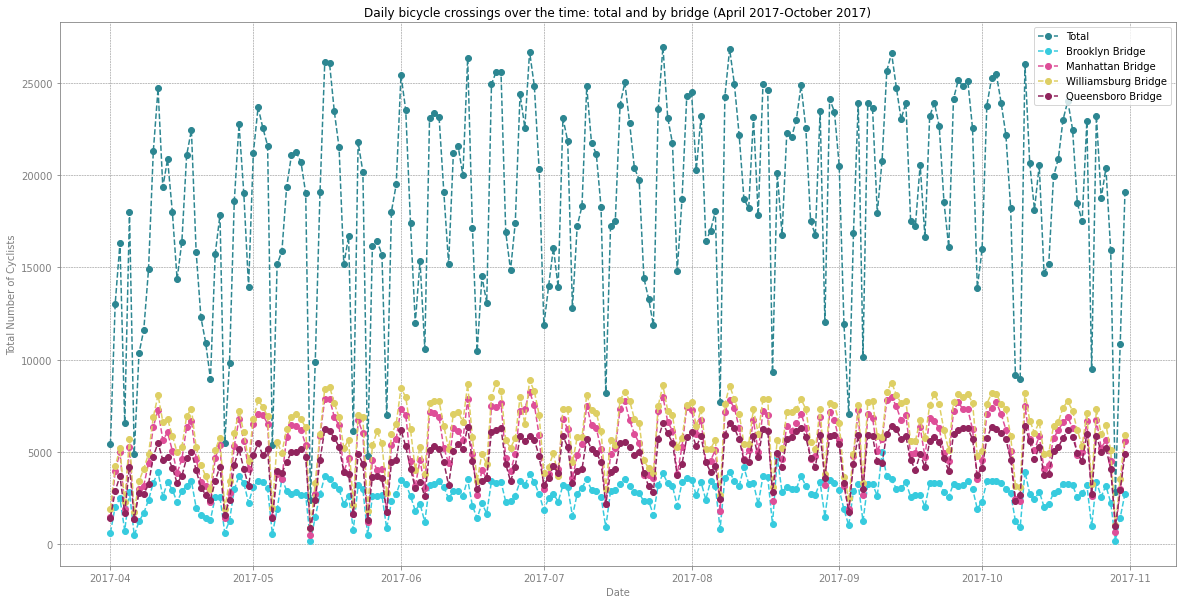

In [30]:
# Total number of cyclists per month per bridge

fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)

ax.plot(total.index, total['Total'], marker = 'o', linestyle="dashed", 
        color='#2C8691', label='Total') 

ax.plot(brooklyn.index, brooklyn['Brooklyn Bridge'], marker = 'o', linestyle="dashed", 
        color='#37CBDE', label='Brooklyn Bridge') 

ax.plot(manhattan.index, manhattan['Manhattan Bridge'], marker = 'o', linestyle='dashed',
        color='#DE4E98', label='Manhattan Bridge')

ax.plot(williamsburg.index, williamsburg['Williamsburg Bridge'], marker='o',
        linestyle='dashed', color='#DECF64', label='Williamsburg Bridge')

ax.plot(queensboro.index, queensboro['Queensboro Bridge'], marker='o',
        linestyle='dashed', color='#91245D', label='Queensboro Bridge')



ax.set_xlabel('Date', fontsize='medium', color='gray')
ax.set_ylabel('Total Number of Cyclists', fontsize='medium', color='gray')
ax.tick_params('y', colors='gray')
ax.tick_params('x', colors='gray')

ax.spines["top"].set_color("gray")
ax.spines["bottom"].set_color("gray")
ax.spines["left"].set_color("gray")
ax.spines["right"].set_color("gray")

ax.set_title('Daily bicycle crossings over the time: total and by bridge (April 2017-October 2017)')
plt.legend()

ax.plot

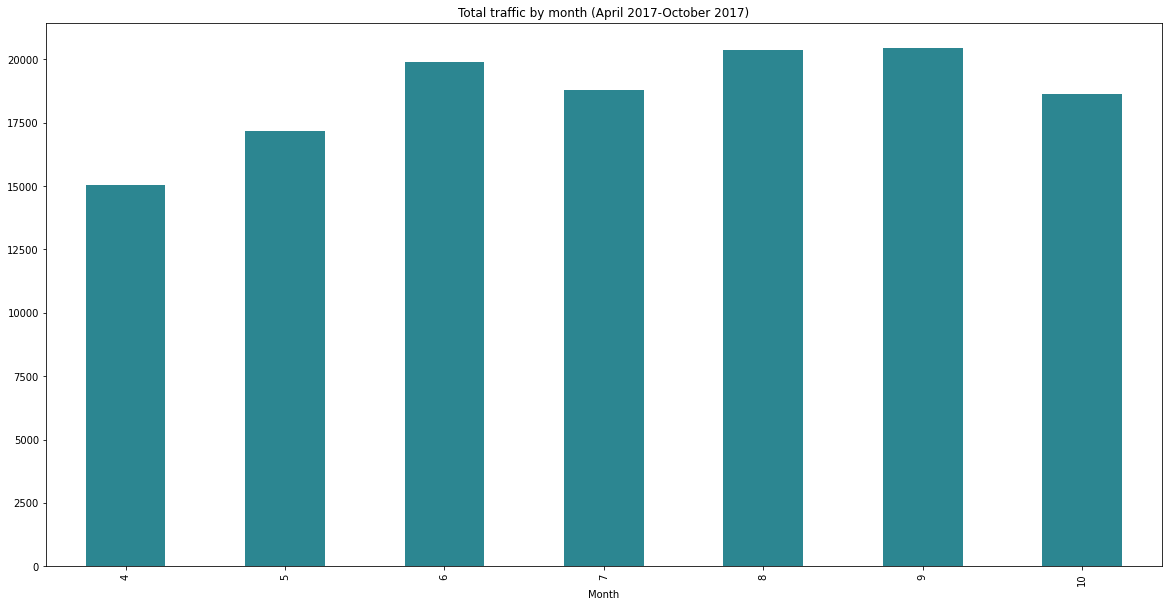

In [31]:
# How total Total number of bike riders differs by Month?
fig, ax = plt.subplots(figsize=(20,10))
months = df.groupby('Month').mean()['Total'].plot(kind='bar', title='Total traffic by month (April 2017-October 2017)', color='#2C8691')
plt.show();

In [32]:
df_day_type = df.groupby(by='Day_type').mean().reset_index()
df_weekend = df_day_type[df_day_type['Day_type']==1]
df_weekday = df_day_type[df_day_type['Day_type']==0]
print(df_day_type.columns)

Index(['Day_type', 'index', 'High Temp (°F)', 'Low Temp (°F)', 'Precipitation',
       'Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge',
       'Queensboro Bridge', 'Total', 'Day_of_week', 'Month', 'All_Days'],
      dtype='object')


Cyclist traffic depends on the week


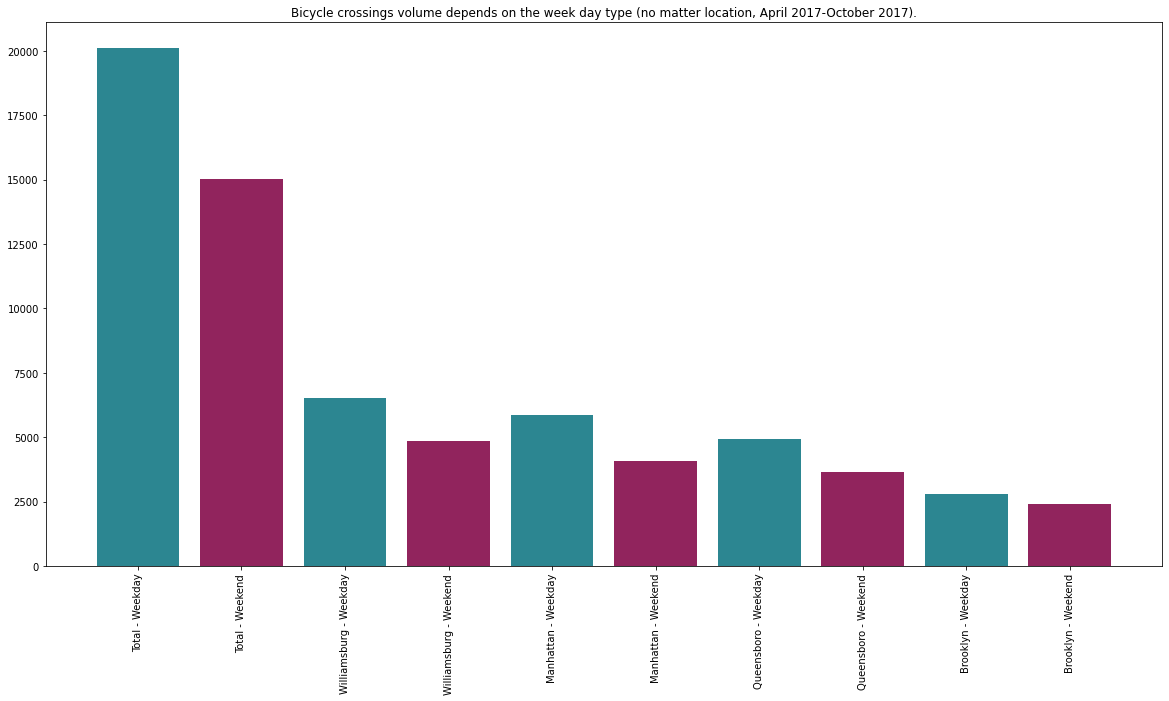

In [257]:
print('Cyclist traffic depends on the week')

fig, ax = plt.subplots(figsize=(20,10))
ax.bar('Total - Weekday', df_weekday['Total'].sum(), color='#2C8691')
ax.bar('Total - Weekend', df_weekend['Total'].sum(), color='#91245D')

ax.bar('Williamsburg - Weekday', df_weekday['Williamsburg Bridge'].sum(), color='#2C8691')
ax.bar('Williamsburg - Weekend', df_weekend['Williamsburg Bridge'].sum(), color='#91245D')

ax.bar('Manhattan - Weekday', df_weekday['Manhattan Bridge'].sum(), color='#2C8691')
ax.bar('Manhattan - Weekend', df_weekend['Manhattan Bridge'].sum(), color='#91245D')

ax.bar('Queensboro - Weekday', df_weekday['Queensboro Bridge'].sum(), color='#2C8691')
ax.bar('Queensboro - Weekend', df_weekend['Queensboro Bridge'].sum(), color='#91245D')


ax.bar('Brooklyn - Weekday', df_weekday['Brooklyn Bridge'].sum(), color='#2C8691')
ax.bar('Brooklyn - Weekend', df_weekend['Brooklyn Bridge'].sum(), color='#91245D')

ax.xaxis.set_tick_params(rotation=90)

ax.set_title('Bicycle crossings volume depends on the week day type (no matter location, April 2017-October 2017).')
plt.show()

Basic descriptive statistics:
Minimal Value: 2374
Maximal Value: 26969
---------------------
Mean: 18627.67757009346
Standard deviation: 5539.557489298311
Median: 19367.0
---------------------
Skewness: -0.7802480909595536
Kurtosis: 0.004853366812207938


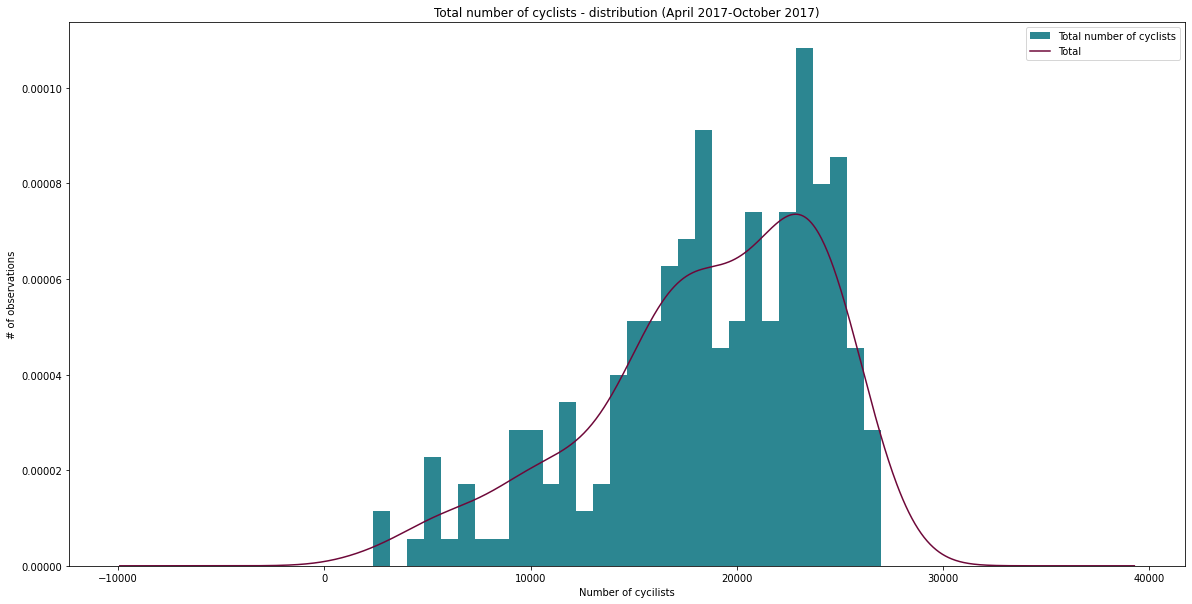

In [33]:
# Distribution of Total Number of Cyclists

min = df['Total'].min()
max = df['Total'].max()
total_mean = df['Total'].mean()
total_std = df['Total'].std()
total_median = df['Total'].median()
total_skew = df['Total'].skew()
total_kurt = df['Total'].kurt()


print('Basic descriptive statistics:')
print(f'Minimal Value: {min}')
print(f'Maximal Value: {max}')
print(f'---------------------')
print(f'Mean: {total_mean}')
print(f'Standard deviation: {total_std}')
print(f'Median: {total_median}')
print(f'---------------------')
print(f'Skewness: {total_skew}')
print(f'Kurtosis: {total_kurt}')

fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(df['Total'], label='Total number of cyclists', density=True, bins=30, color='#2C8691')
df['Total'].plot(kind='density', color='#6E0839')

plt.legend()

ax.set_xlabel("Number of cycilists")
ax.set_ylabel("# of observations")
ax.set_title('Total number of cyclists - distribution (April 2017-October 2017)')
plt.show();


Basic descriptive statistics:
Minimal Value: 874
Maximal Value: 8873
---------------------
Mean: 6051.658878504673
Standard deviation: 1755.814990866307
Median: 6287.0
---------------------
Skewness: -0.7191858055144873
Kurtosis: 0.004853366812207938


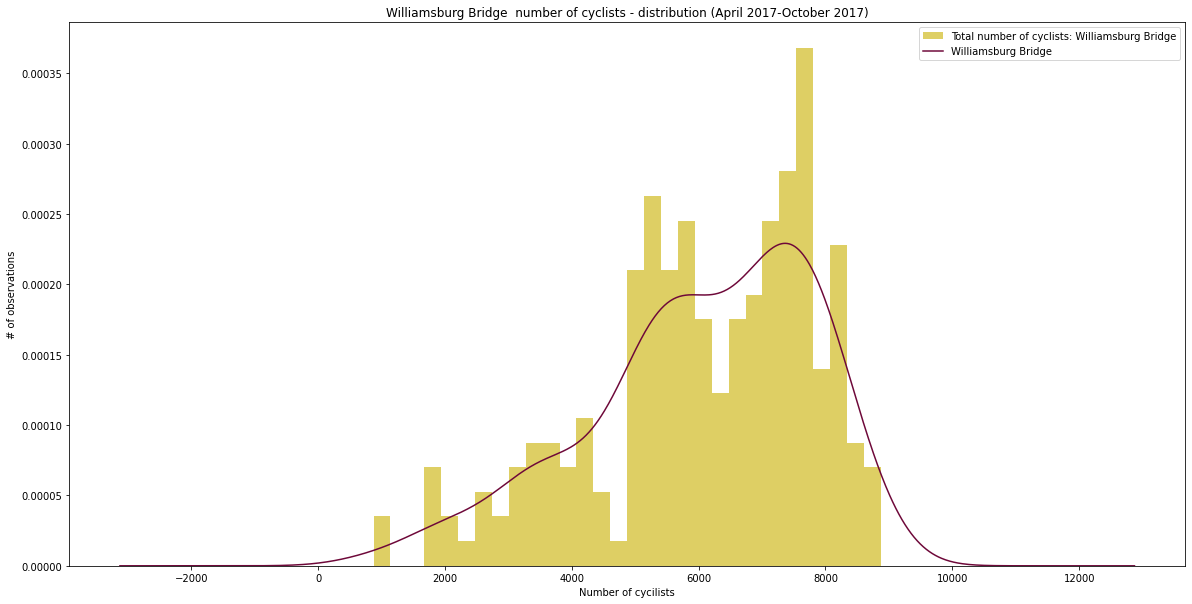

In [79]:
# Distribution of Williamsburg Bridge
min = df['Williamsburg Bridge'].min()
max = df['Williamsburg Bridge'].max()
w_mean = df['Williamsburg Bridge'].mean()
w_std = df['Williamsburg Bridge'].std()
w_median = df['Williamsburg Bridge'].median()
w_skew = df['Williamsburg Bridge'].skew()
w_kurt = df['Total'].kurt()


print('Basic descriptive statistics:')
print(f'Minimal Value: {min}')
print(f'Maximal Value: {max}')
print(f'---------------------')
print(f'Mean: {w_mean}')
print(f'Standard deviation: {w_std}')
print(f'Median: {w_median}')
print(f'---------------------')
print(f'Skewness: {w_skew}')
print(f'Kurtosis: {w_kurt}')

fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(df['Williamsburg Bridge'], label='Total number of cyclists: Williamsburg Bridge', density=True, bins=30, color='#DECF64')
df['Williamsburg Bridge'].plot(kind='density', color='#6E0839')

plt.legend()

ax.set_xlabel("Number of cycilists")
ax.set_ylabel("# of observations")
ax.set_title('Williamsburg Bridge  number of cyclists - distribution (April 2017-October 2017)')
plt.show();

Basic descriptive statistics:
Minimal Value: 484
Maximal Value: 8239
---------------------
Mean: 5345.485981308411
Standard deviation: 1746.5465232906097
Median: 5607.5
---------------------
Skewness: -0.6118281149413726
Kurtosis: -0.3432684667987047


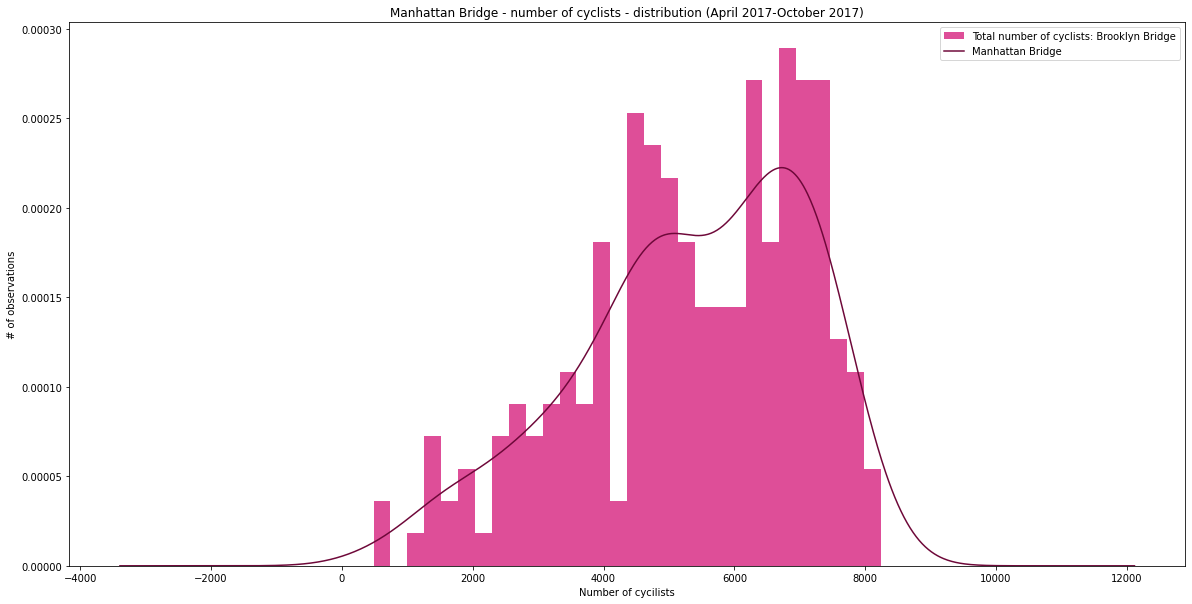

In [34]:
# Distribution of Manhattan Bridge
min = df['Manhattan Bridge'].min()
max = df['Manhattan Bridge'].max()
m_mean = df['Manhattan Bridge'].mean()
m_std = df['Manhattan Bridge'].std()
m_median = df['Manhattan Bridge'].median()
m_skew = df['Manhattan Bridge'].skew()
m_kurt = df['Manhattan Bridge'].kurt()


print('Basic descriptive statistics:')
print(f'Minimal Value: {min}')
print(f'Maximal Value: {max}')
print(f'---------------------')
print(f'Mean: {m_mean}')
print(f'Standard deviation: {m_std}')
print(f'Median: {m_median}')
print(f'---------------------')
print(f'Skewness: {m_skew}')
print(f'Kurtosis: {m_kurt}')

fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(df['Manhattan Bridge'], label='Total number of cyclists: Brooklyn Bridge', density=True, bins=30, color='#DE4E98')
df['Manhattan Bridge'].plot(kind='density', color='#6E0839')

plt.legend()

ax.set_xlabel("Number of cycilists")
ax.set_ylabel("# of observations")
ax.set_title('Manhattan Bridge - number of cyclists - distribution (April 2017-October 2017)')
plt.show();

Basic descriptive statistics:
Minimal Value: 865
Maximal Value: 6582
---------------------
Mean: 4550.490654205608
Standard deviation: 1306.8997459337254
Median: 4681.0
---------------------
Skewness: -0.661625509449612
Kurtosis: -0.1574285207351238


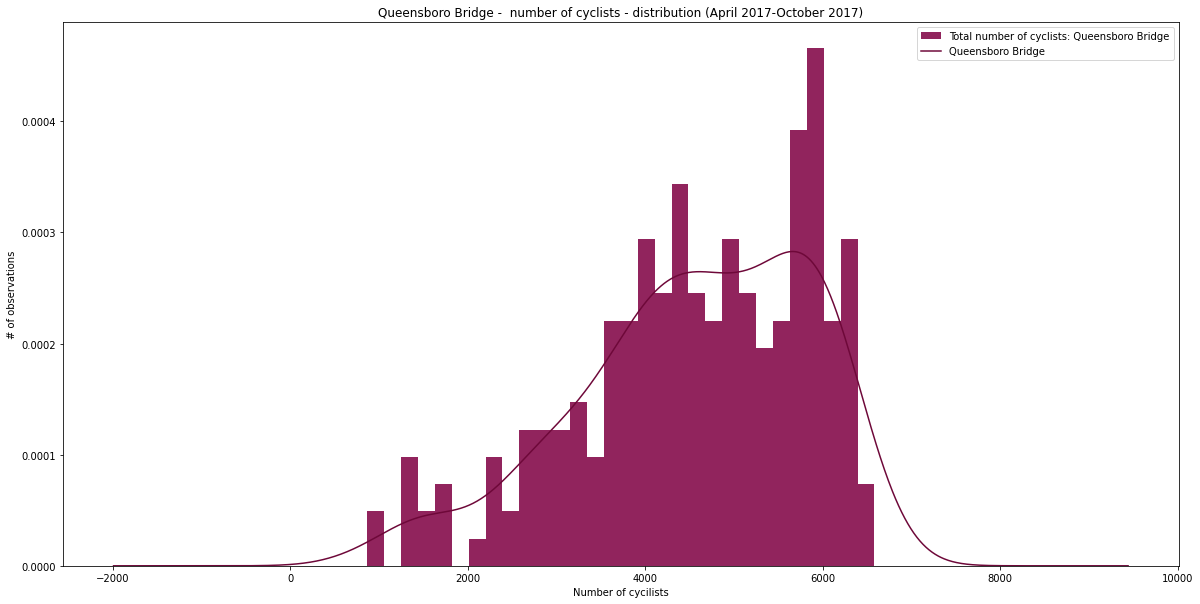

In [35]:
# Distribution of Queensboro Bridge
min = df['Queensboro Bridge'].min()
max = df['Queensboro Bridge'].max()
q_mean = df['Queensboro Bridge'].mean()
q_std = df['Queensboro Bridge'].std()
q_median = df['Queensboro Bridge'].median()
q_skew = df['Queensboro Bridge'].skew()
q_kurt = df['Queensboro Bridge'].kurt()


print('Basic descriptive statistics:')
print(f'Minimal Value: {min}')
print(f'Maximal Value: {max}')
print(f'---------------------')
print(f'Mean: {q_mean}')
print(f'Standard deviation: {q_std}')
print(f'Median: {q_median}')
print(f'---------------------')
print(f'Skewness: {q_skew}')
print(f'Kurtosis: {q_kurt}')

fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(df['Queensboro Bridge'], label='Total number of cyclists: Queensboro Bridge', density=True, bins=30, color='#91245D')
df['Queensboro Bridge'].plot(kind='density', color='#6E0839')

plt.legend()

ax.set_xlabel("Number of cycilists")
ax.set_ylabel("# of observations")
ax.set_title('Queensboro Bridge -  number of cyclists - distribution (April 2017-October 2017)')
plt.show();

Basic descriptive statistics:
Minimal Value: 151
Maximal Value: 4960
---------------------
Mean: 2680.042056074766
Standard deviation: 854.7108635057903
Median: 2857.0
---------------------
Skewness: -0.8808288319498353
Kurtosis: 0.6501885350498893


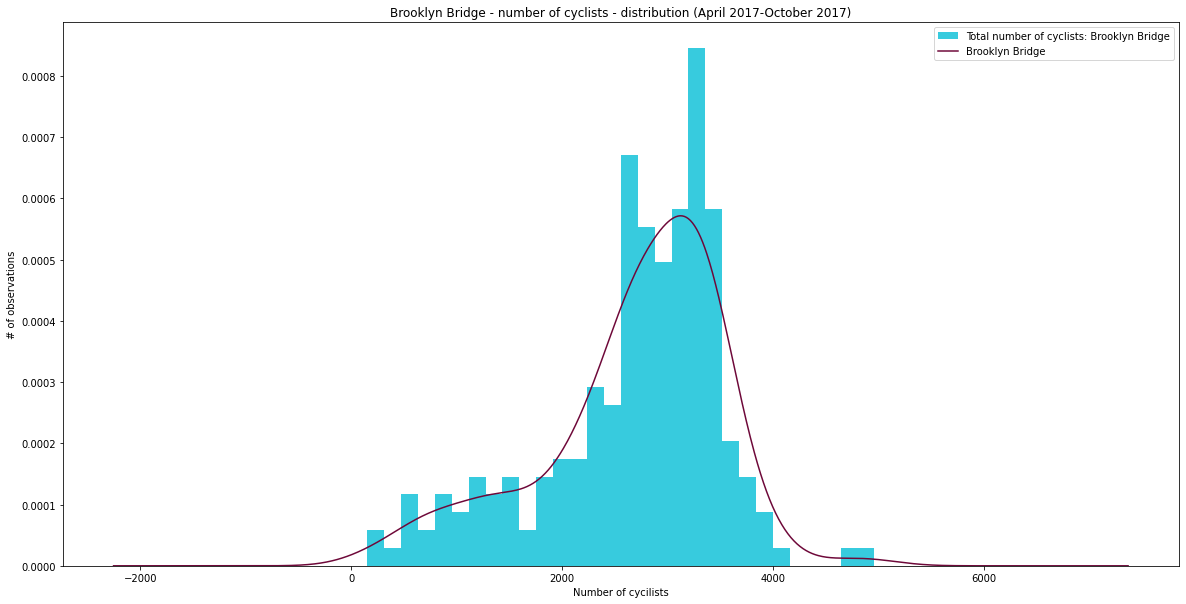

In [36]:
# Distribution of Brooklyn Bridge
min = df['Brooklyn Bridge'].min()
max = df['Brooklyn Bridge'].max()
b_mean = df['Brooklyn Bridge'].mean()
b_std = df['Brooklyn Bridge'].std()
b_median = df['Brooklyn Bridge'].median()
b_skew = df['Brooklyn Bridge'].skew()
b_kurt = df['Brooklyn Bridge'].kurt()


print('Basic descriptive statistics:')
print(f'Minimal Value: {min}')
print(f'Maximal Value: {max}')
print(f'---------------------')
print(f'Mean: {b_mean}')
print(f'Standard deviation: {b_std}')
print(f'Median: {b_median}')
print(f'---------------------')
print(f'Skewness: {b_skew}')
print(f'Kurtosis: {b_kurt}')

fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(df['Brooklyn Bridge'], label='Total number of cyclists: Brooklyn Bridge', density=True, bins=30, color='#37CBDE')
df['Brooklyn Bridge'].plot(kind='density', color='#6E0839')

plt.legend()

ax.set_xlabel("Number of cycilists")
ax.set_ylabel("# of observations")
ax.set_title('Brooklyn Bridge - number of cyclists - distribution (April 2017-October 2017)')
plt.show();

Are data correlated?


In [37]:
corr_matrix = df.corr()
corr_matrix

,index,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,Day_of_week,Day_type,Month,All_Days
index,1.000000,0.047930,0.105662,-0.022229,0.023856,0.040663,0.055504,0.058251,0.047836,-0.002368,-0.016294,0.008061,NaN
High Temp (°F),0.047930,1.000000,0.888940,-0.190442,0.494041,0.463184,0.479344,0.501628,0.492540,0.006454,-0.014325,0.266615,NaN
Low Temp (°F),0.105662,0.888940,1.000000,-0.050033,0.294227,0.287516,0.314370,0.351267,0.318561,-0.025821,-0.042696,0.302415,NaN
Precipitation,-0.022229,-0.190442,-0.050033,1.000000,-0.590547,-0.549799,-0.560134,-0.538428,-0.568953,0.055126,0.054951,-0.065696,NaN
Brooklyn Bridge,0.023856,0.494041,0.294227,-0.590547,1.000000,0.893562,0.886907,0.876249,0.923860,-0.133936,-0.188534,0.182443,NaN
Manhattan Bridge,0.040663,0.463184,0.287516,-0.549799,0.893562,1.000000,0.982223,0.959859,0.990932,-0.369524,-0.461452,0.186828,NaN
Williamsburg Bridge,0.055504,0.479344,0.314370,-0.560134,0.886907,0.982223,1.000000,0.963411,0.990773,-0.317666,-0.431640,0.191594,NaN
Queensboro Bridge,0.058251,0.501628,0.351267,-0.538428,0.876249,0.959859,0.963411,1.000000,0.979112,-0.331856,-0.447190,0.341065,NaN
Total,0.047836,0.492540,0.318561,-0.568953,0.923860,0.990932,0.990773,0.979112,1.000000,-0.316150,-0.416893,0.228246,NaN
Day_of_week,-0.002368,0.006454,-0.025821,0.055126,-0.133936,-0.369524,-0.317666,-0.331856,-0.316150,1.000000,0.793710,-0.008140,NaN


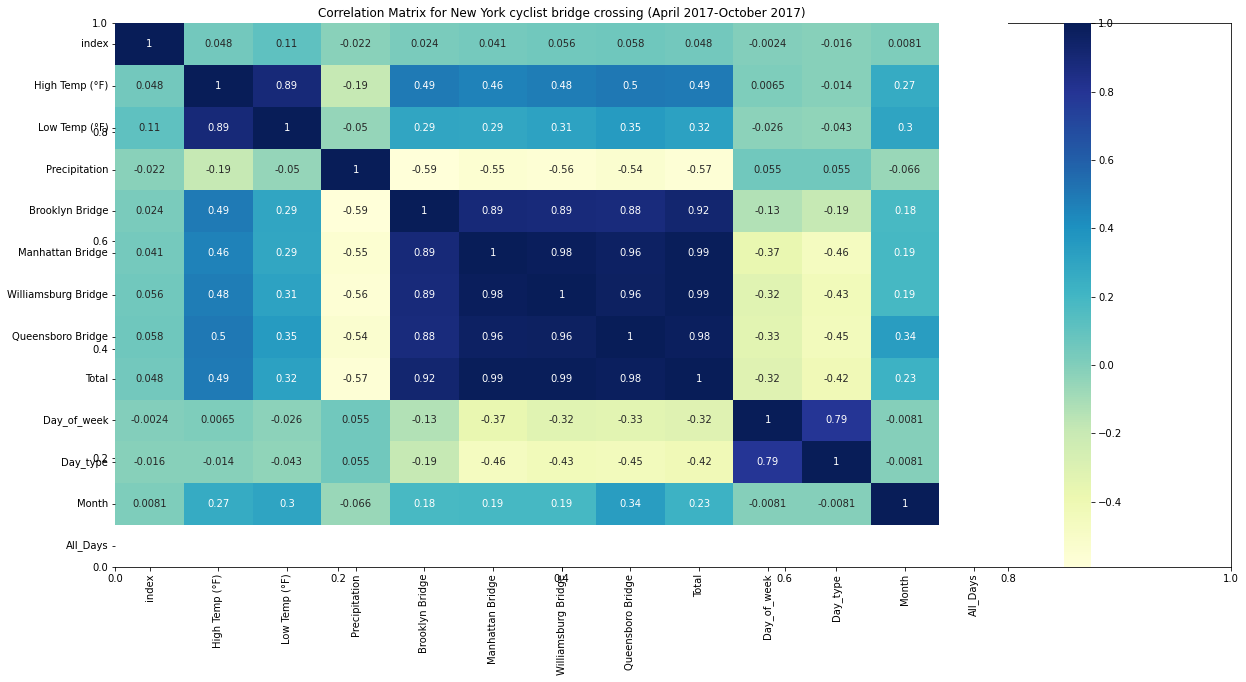

In [38]:
fig, ax = plt.subplots(figsize=(20,10))

ax = plt.axes()
sns.heatmap(corr_matrix, cmap="YlGnBu",
             annot=True, ax=ax)
ax.set_title('Correlation Matrix for New York cyclist bridge crossing (April 2017-October 2017)')
plt.show();

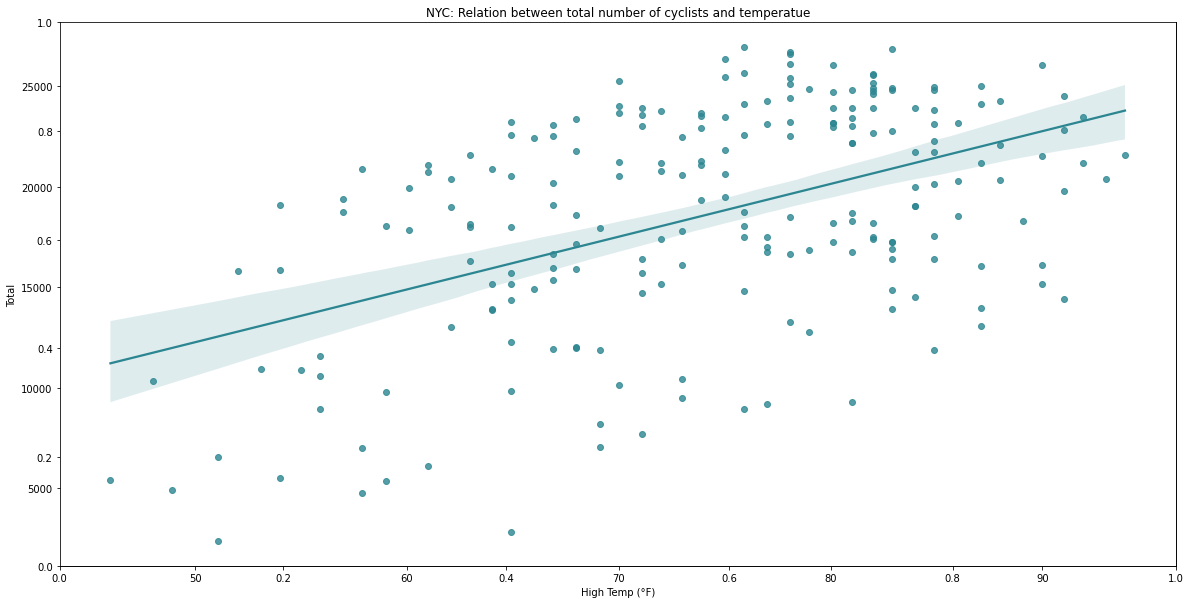

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.regplot(y='Total', x='High Temp (°F)', data=df, color='#2C8691', label=True)
ax.set_title('NYC: Relation between total number of cyclists and temperatue')
plt.show();

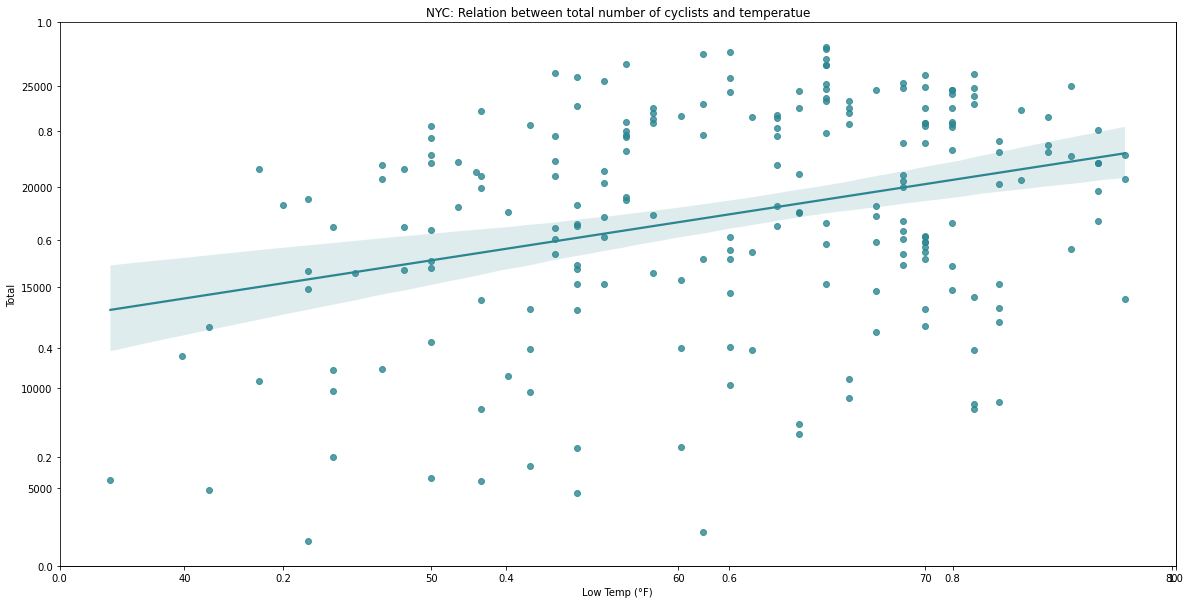

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.regplot(y='Total', x='Low Temp (°F)', data=df, color='#2C8691', label=True)
ax.set_title('NYC: Relation between total number of cyclists and temperatue')
plt.show()

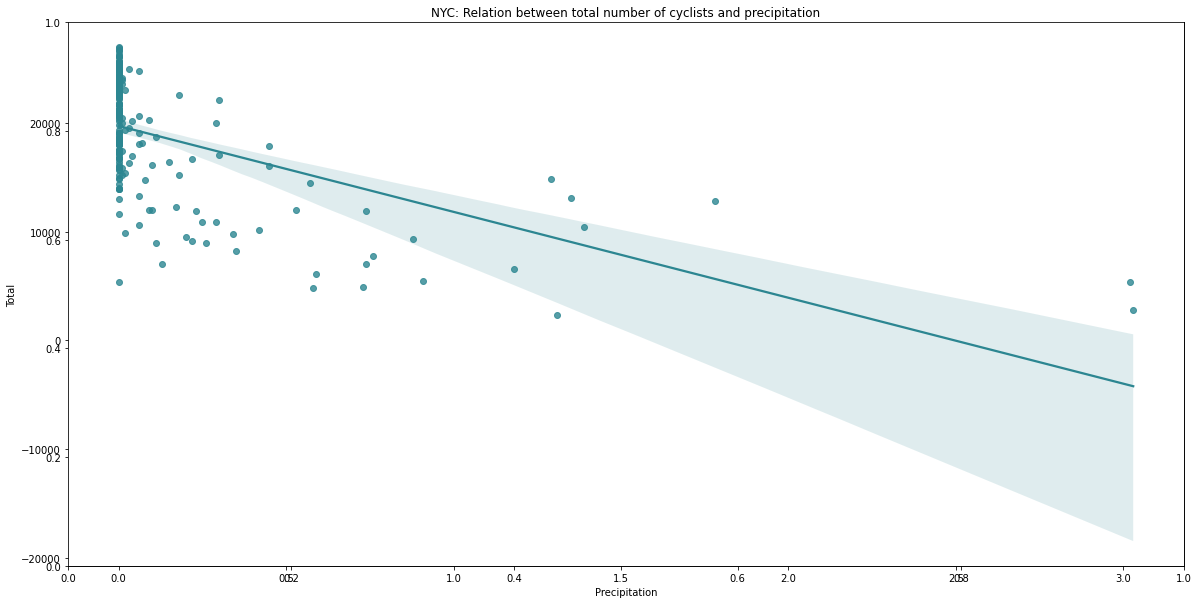

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.regplot(y='Total', x='Precipitation', data=df, color='#2C8691', label=True)
ax.set_title('NYC: Relation between total number of cyclists and precipitation')
plt.show()

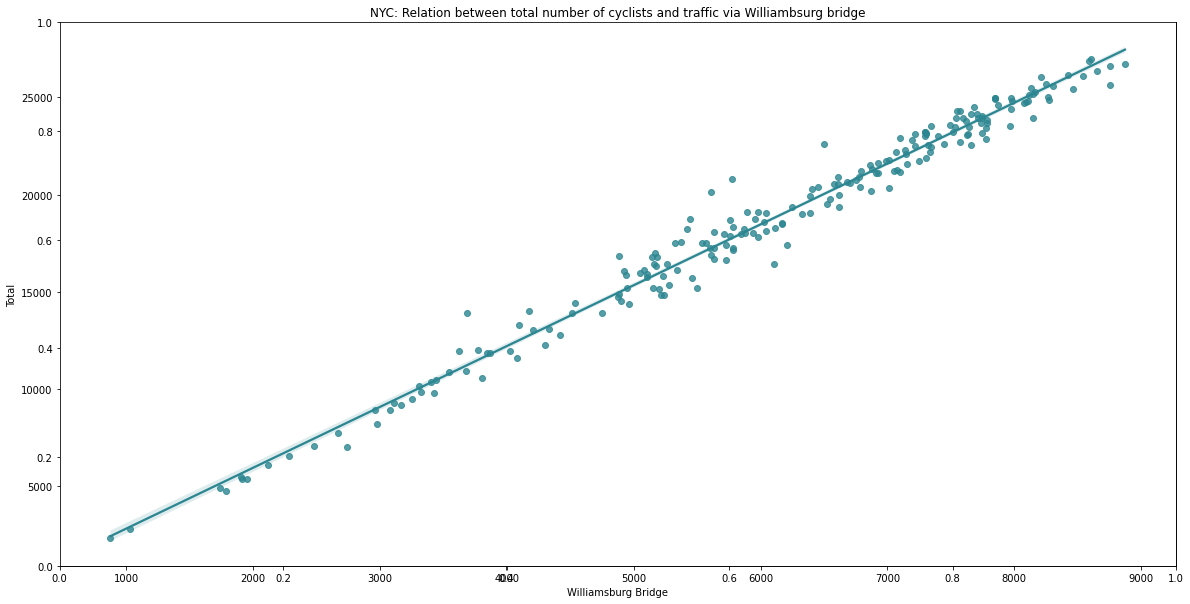

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.regplot(y='Total', x='Williamsburg Bridge', data=df, color='#2C8691', label=True)
ax.set_title('NYC: Relation between total number of cyclists and traffic via Williambsurg bridge')
plt.show()

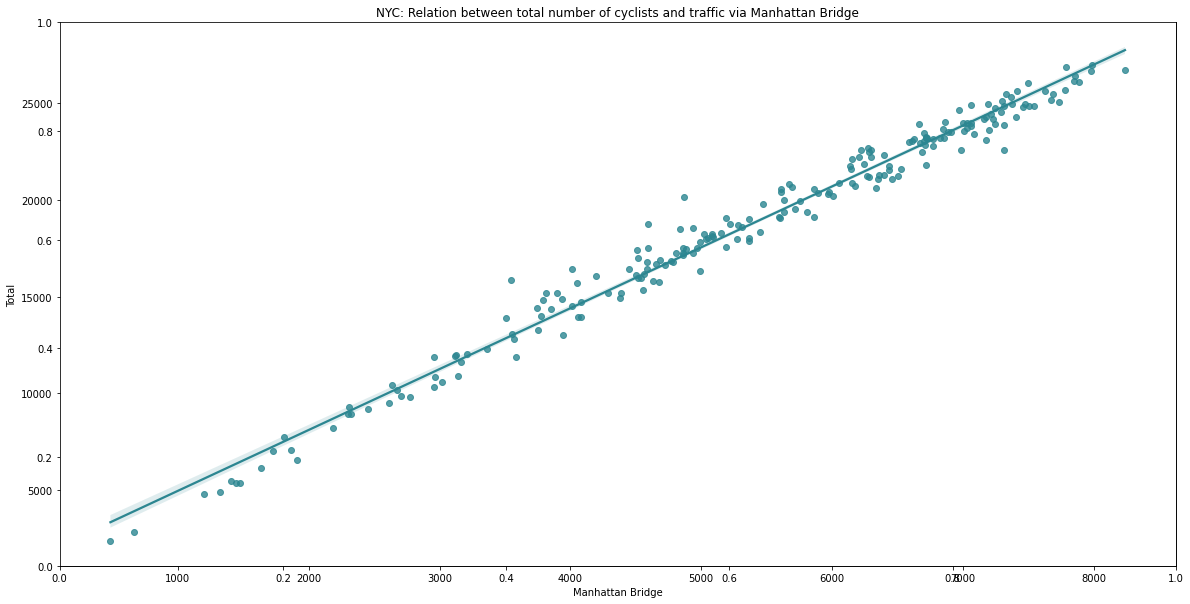

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.regplot(y='Total', x='Manhattan Bridge', data=df, color='#2C8691', label=True)
ax.set_title('NYC: Relation between total number of cyclists and traffic via Manhattan Bridge')
plt.show()

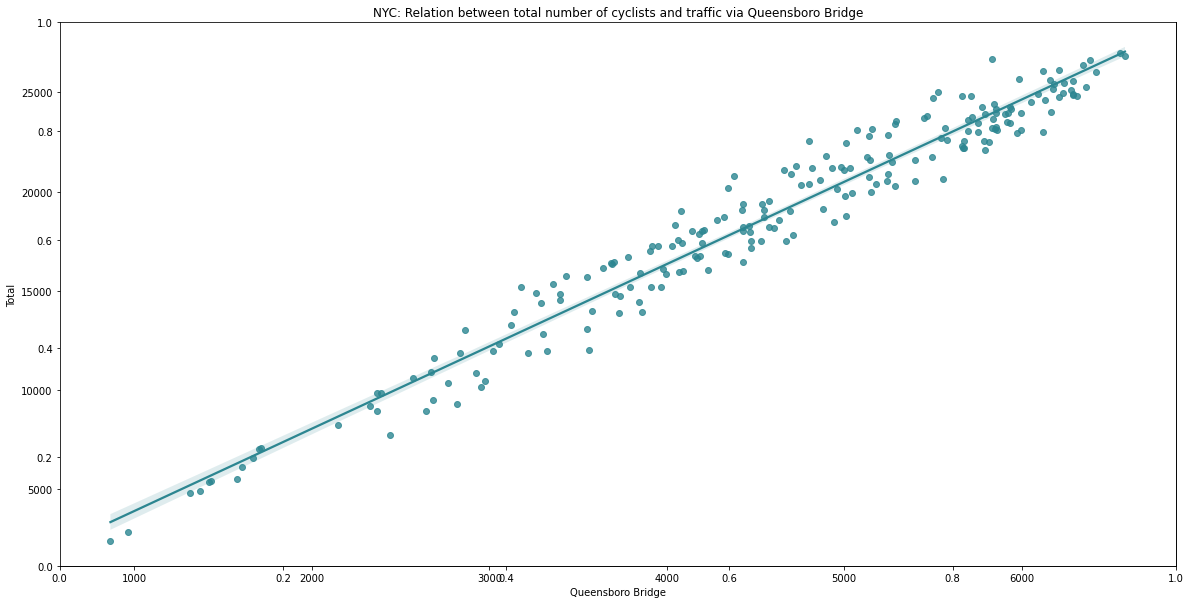

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.regplot(y='Total', x='Queensboro Bridge', data=df, color='#2C8691', label=True)
ax.set_title('NYC: Relation between total number of cyclists and traffic via Queensboro Bridge')
plt.show()

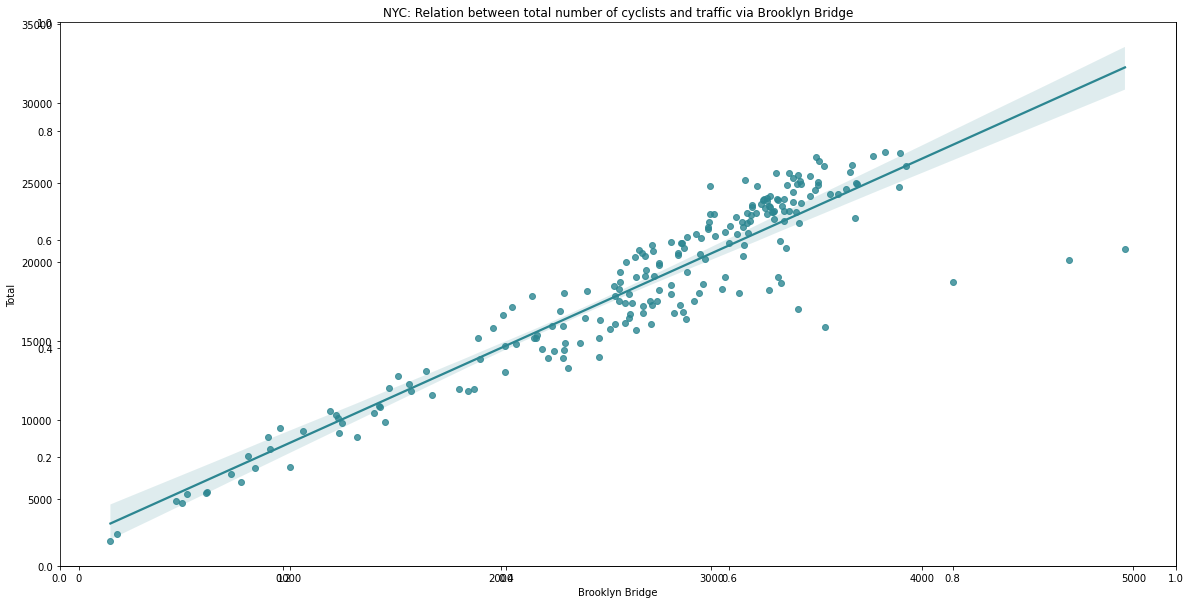

In [45]:
#Są outliery, na razie je zostawiam.
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.regplot(y='Total', x='Brooklyn Bridge', data=df, color='#2C8691', label=True)
ax.set_title('NYC: Relation between total number of cyclists and traffic via Brooklyn Bridge')
plt.show()

**Train Test Split and preprocessing**

In [57]:
# Zmienne zależne i niezależne - w1
X = df[['High Temp (°F)', 'Low Temp (°F)', 'Precipitation', 'Day_of_week', 'Day_type','Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']]
y = df['Total']

In [87]:
X

,High Temp (°F),Low Temp (°F),Precipitation,Day_of_week,Day_type,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
0,46.0,37.0,0.00,6,1,606,1446,1915,1430
1,62.1,41.0,0.00,7,1,2021,3943,4207,2862
2,63.0,50.0,0.03,1,0,2470,4988,5178,3689
3,51.1,46.0,1.18,2,0,723,1913,2279,1666
4,63.0,46.0,0.00,3,0,2807,5276,5711,4197
...,...,...,...,...,...,...,...,...,...
209,62.1,48.0,0.00,5,0,3150,5610,6450,5181
210,68.0,55.9,0.00,6,1,2245,4520,5104,4069
211,64.9,61.0,3.03,7,1,183,661,1026,965
212,55.0,46.0,0.25,1,0,1428,2966,3547,2924


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(214, 9) (214,)
(143, 9) (143,)
(71, 9) (71,)


In [88]:
X_train

,High Temp (°F),Low Temp (°F),Precipitation,Day_of_week,Day_type,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
100,82.9,71.1,0.00,1,0,3506,7503,8106,5712
148,77.0,63.0,0.00,7,1,2676,4785,5145,4159
172,78.1,71.1,0.00,3,0,3296,6826,7518,5570
99,81.0,69.1,0.00,7,1,3048,5446,5782,4044
116,75.9,66.0,0.00,3,0,3821,7987,8605,6556
...,...,...,...,...,...,...,...,...,...
169,80.1,70.0,0.00,7,1,2676,4935,5599,4032
19,64.9,50.0,0.17,4,0,1567,3365,4302,3056
86,78.1,66.0,0.00,1,0,3386,7217,7974,5845
108,87.1,75.9,0.00,2,0,3507,7732,8268,5531


In [59]:
imputer = SimpleImputer(strategy = 'mean')

In [60]:
imputed_X_train = imputer.fit_transform(X_train)
imputed_X_test = imputer.transform(X_test)

In [86]:
imputed_X_train

array([[8.290e+01, 7.110e+01, 0.000e+00, ..., 7.503e+03, 8.106e+03,
        5.712e+03],
       [7.700e+01, 6.300e+01, 0.000e+00, ..., 4.785e+03, 5.145e+03,
        4.159e+03],
       [7.810e+01, 7.110e+01, 0.000e+00, ..., 6.826e+03, 7.518e+03,
        5.570e+03],
       ...,
       [7.810e+01, 6.600e+01, 0.000e+00, ..., 7.217e+03, 7.974e+03,
        5.845e+03],
       [8.710e+01, 7.590e+01, 0.000e+00, ..., 7.732e+03, 8.268e+03,
        5.531e+03],
       [8.290e+01, 7.110e+01, 1.290e+00, ..., 3.933e+03, 5.214e+03,
        3.396e+03]])

In [61]:
scaler = StandardScaler()

In [62]:
scaled_X_train = scaler.fit_transform(imputed_X_train)
scaled_X_test = scaler.transform(imputed_X_test)

In [85]:
scaled_X_train

array([[ 0.83666068,  0.98776832, -0.35864494, ...,  1.12568347,
         1.08191872,  0.81334905],
       [ 0.2536173 ,  0.105495  , -0.35864494, ..., -0.37934528,
        -0.54765008, -0.34139736],
       [ 0.3623203 ,  0.98776832, -0.35864494, ...,  0.7508106 ,
         0.7583164 ,  0.70776373],
       ...,
       [ 0.3623203 ,  0.43226289, -0.35864494, ...,  0.96731768,
         1.0092733 ,  0.91224233],
       [ 1.2517085 ,  1.51059695, -0.35864494, ...,  1.25248684,
         1.17107446,  0.67876495],
       [ 0.83666068,  0.98776832,  2.43534564, ..., -0.85112029,
        -0.50967634, -0.90873253]])

### Linear Regression

In [82]:
model_slr = LinearRegression()
model_slr.fit(scaled_X_train, y_train)

intercept_slr = model_slr.intercept_  
coef_slr = model_slr.coef_ 

y_predict_slr = model_slr.predict(scaled_X_test)

r2_slr = r2_score(y_test, y_predict_slr)
mae_slr = mean_absolute_error(y_test,y_predict_slr)
mape_slr = mean_absolute_percentage_error(y_test, y_predict_slr)
rmse_slr = np.sqrt(mean_squared_error(y_test, y_predict_slr))
results = sm.OLS(y_train, scaled_X_train).fit()

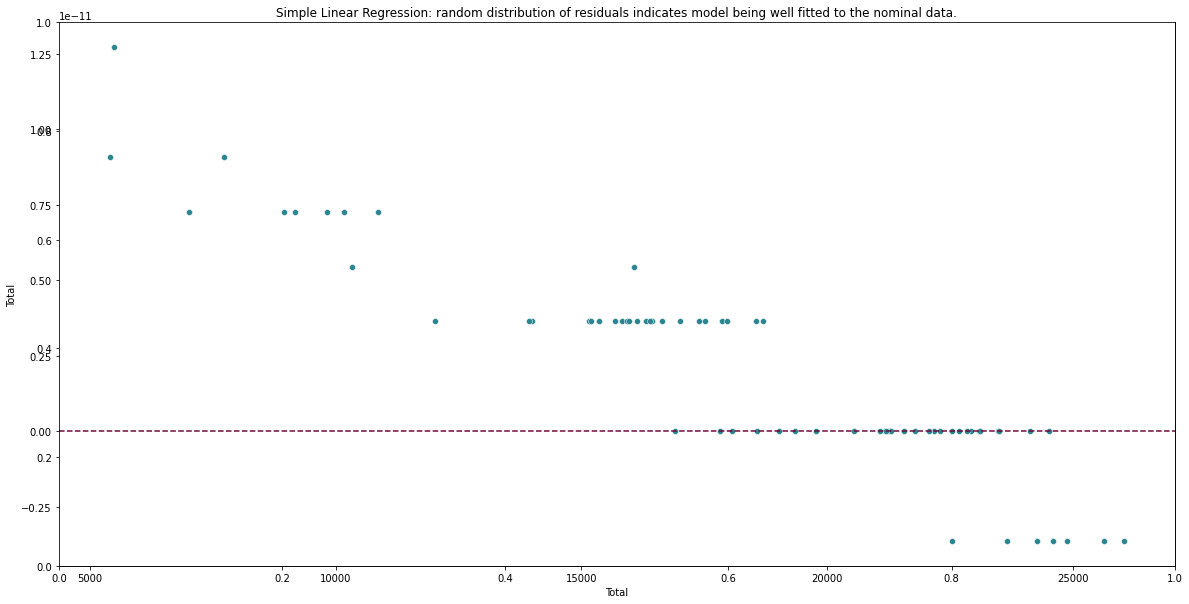

In [83]:
#Residuals distribution plotting to judge, how well the regression line fits the nominal data
test_residuals = y_test - y_predict_slr

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.scatterplot(x=y_test, y=test_residuals, color='#2C8691')
plt.axhline(y=0, ls='--', color='#6E0839')
ax.set_title('Simple Linear Regression: random distribution of residuals indicates model being well fitted to the nominal data.')
plt.show()


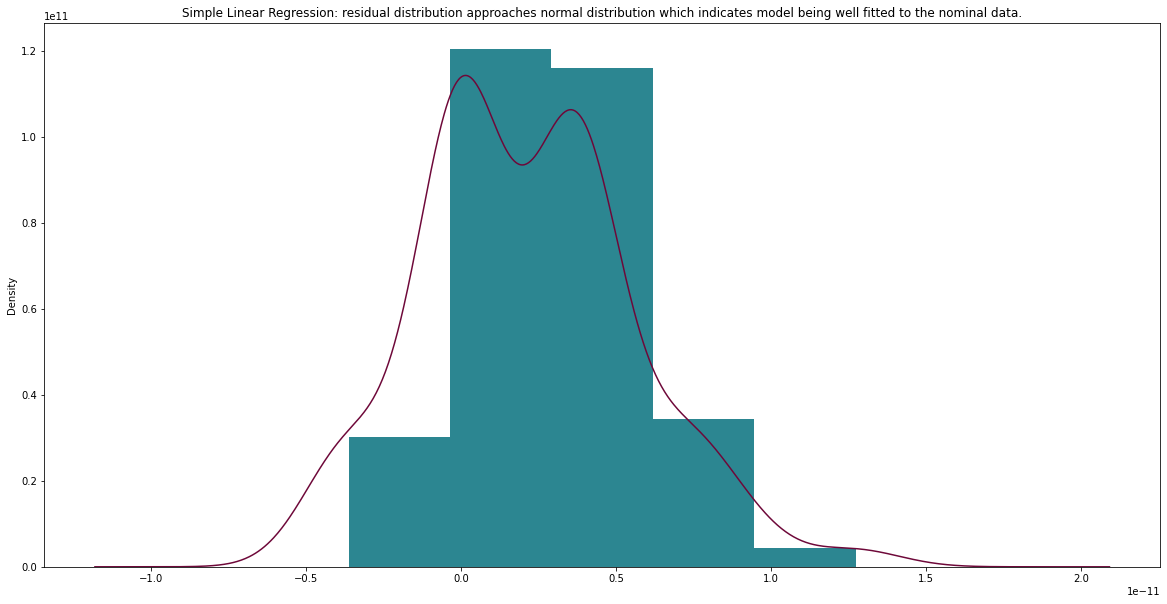

In [84]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(test_residuals,  density=True, bins=5, color='#2C8691')
test_residuals.plot(kind='density', color='#6E0839')
ax.set_title('Simple Linear Regression: residual distribution approaches normal distribution which indicates model being well fitted to the nominal data.')
plt.show();

In [66]:
print('Simple Linear Regression model results:')
print(f'- regression line intercept: {intercept_slr}')
print(f'- regression line coefficients:\n {coef_slr}')
print(f'How well does model predict the bike traffic?')
print(f'- R2 Score: {r2_slr}')
print(f'- MAE: {mae_slr}')
print(f'- MAPE: {mape_slr}')
print(f'- RMSE: {rmse_slr}')
print('-----------------------------------')
print('The most important factors for predictions are:\n a) traffic on the manhattan bridge,\n b) type of the day: weekend or weekday, \c) precipitation.')

print('-----------------------------------')
results.summary()  

Simple Linear Regression model results:
- regression line intercept: 18965.04895104895
- regression line coefficients:
 [-1.20861315e-12  9.09494702e-13 -1.02318154e-12  6.43041176e-13
 -5.80868686e-13  8.77382305e+02  1.80594558e+03  1.81704510e+03
  1.34488403e+03]
How well does model predict the bike traffic?
- R2 Score: 1.0
- MAE: 2.8437721661069022e-12
- MAPE: 2.4727726256623927e-16
- RMSE: 3.986375309218678e-12
-----------------------------------
The most important factors for predictions are:
 a) traffic on the manhattan bridge,
 b) type of the day: weekend or weekday, \c) precipitation.
-----------------------------------


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1667: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
C:\Users\aekal\AppData\Local\Programs\Python\Python310

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Total   R-squared (uncentered):                   0.083
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              1.351
Date:                Mon, 06 Feb 2023   Prob (F-statistic):                       0.217
Time:                        18:55:00   Log-Likelihood:                         -1611.5
No. Observations:                 143   AIC:                                      3241.
Df Residuals:                     134   BIC:                                      3268.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -5.713e-11   4096.480  -1.39e-14      1.000   -8102.123    8102.123
x2          4.434e-11   3719.139   1.19e-14      1.000   -7355.809    7355.809
x3          3.809e-12   2193.009   1.74e-15      1.000   -4337.390    4337.390
x4          6.594e-12   2887.499   2.28e-15      1.000   -5710.971    5710.971
x5         -2.501e-12   3208.908  -7.79e-16      1.000   -6346.661    6346.661
x6           877.3823   4357.307      0.201      0.841   -7740.613    9495.377
x7          1805.9456   1.15e+04      0.157      0.875   -2.09e+04    2.45e+04
x8          1817.0451   1.09e+04      0.167      0.868   -1.98e+04    2.34e+04
x9          1344.8840   6790.533      0.198      0.843   -1.21e+04    1.48e+04
==============================================================================
Omnibus:                        2.628   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                2.124
Skew:                           0.254   Prob(JB):                        0.346
Kurtosis:                       3.314   Cond. No.                         20.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Polynomial regression

In [67]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(scaled_X_train)
X_test_poly = poly.transform(scaled_X_test)

model_plr = LinearRegression()
model_plr.fit(X_train_poly, y_train)

y_predict_plr = model_plr.predict(X_test_poly)

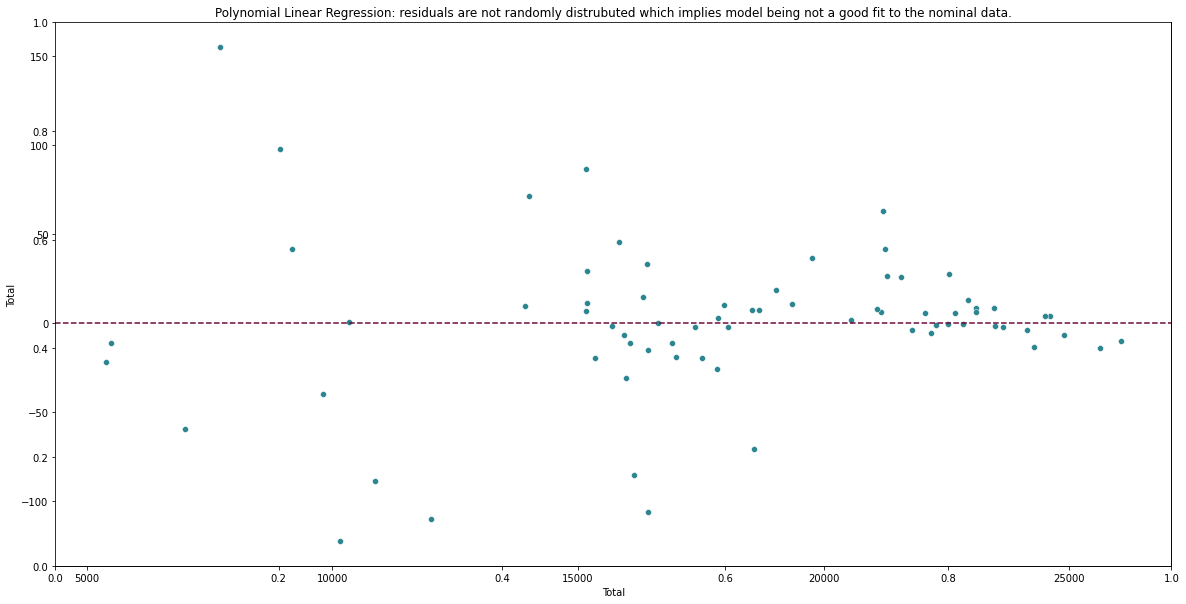

In [68]:
#Residuals distribution plotting to judge, how well the regression line fits the nominal data
test_residuals = y_test - y_predict_plr

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.scatterplot(x=y_test, y=test_residuals, color='#2C8691')
plt.axhline(y=0, ls='--', color='#6E0839')
ax.set_title('Polynomial Linear Regression: residuals are not randomly distrubuted which implies model being not a good fit to the nominal data.')
plt.show()

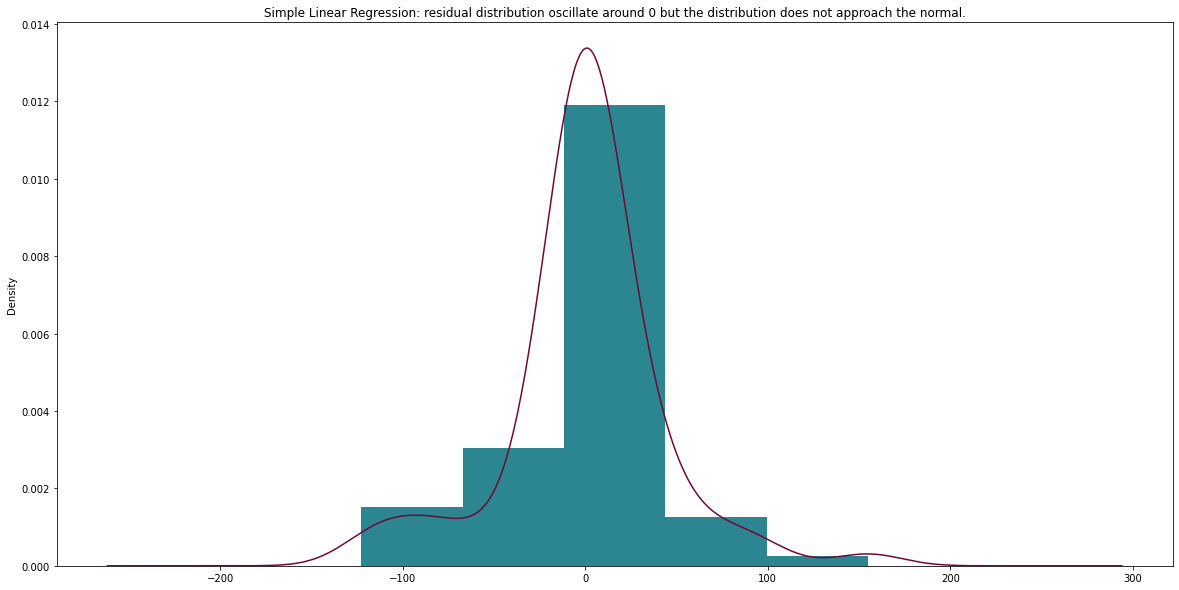

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(test_residuals,  density=True, bins=5, color='#2C8691')
test_residuals.plot(kind='density', color='#6E0839')
ax.set_title('Simple Linear Regression: residual distribution oscillate around 0 but the distribution does not approach the normal.')
plt.show();

In [71]:
intercept_plr = model_plr.intercept_  
coef_plr = model_plr.coef_ 

r2_plr = r2_score(y_test, y_predict_plr)
mae_plr = mean_absolute_error(y_test,y_predict_plr)
mape_plr = mean_absolute_percentage_error(y_test, y_predict_plr)
rmse_plr = np.sqrt(mean_squared_error(y_test, y_predict_plr))
results = sm.OLS(y_train,X_train_poly).fit()

In [72]:
print('Polynomial Linear Regression model results:')
print(f'- regression line intercept: {intercept_plr}')
# print(f'- regression line coefficients:\n {coef_plr}')
print(f'How well does model predict the bike traffic?')
print(f'- R2 Score: {r2_plr}')
print(f'- MAE: {mae_plr}')
print(f'- MAPE: {mape_plr}')
print(f'- RMSE: {rmse_plr}')
print('-----------------------------------')
print('The most important factors for predictions are:\n a) traffic on the manhattan bridge,\n b) type of the day: weekend or weekday.')

print('-----------------------------------')
results.summary()  

Polynomial Linear Regression model results:
- regression line intercept: 19010.08506845041
How well does model predict the bike traffic?
- R2 Score: 0.9999278746043204
- MAE: 26.76711004837768
- MAPE: 0.0020999385707061147
- RMSE: 43.01076266082578
-----------------------------------
The most important factors for predictions are:
 a) traffic on the manhattan bridge,
 b) type of the day: weekend or weekday.
-----------------------------------


C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\aekal\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 06 Feb 2023   Prob (F-statistic):                nan
Time:                        19:00:02   Log-Likelihood:                 2803.2
No. Observations:                 143   AIC:                            -5320.
Df Residuals:                       0   BIC:                            -4897.
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.191e+04        inf          0        nan         nan         nan
x1           -31.4871        inf         -0        nan         nan         nan
x2           -31.8401        inf         -0        nan         nan         nan
x3          -346.5944        inf         -0        nan         nan         nan
x4           104.8039        inf          0        nan         nan         nan
x5         -6083.3488        inf         -0        nan         nan         nan
x6           432.1791        inf          0        nan         nan         nan
x7           894.9629        inf          0        nan         nan         nan
x8          1525.8213        inf          0        nan         nan         nan
x9          1099.0914        inf          0        nan         nan         nan
x10          139.4460        inf          0        nan         nan         nan
x11         -180.7249        inf         -0        nan         nan         nan
x12         -347.0529        inf         -0        nan         nan         nan
x13         -162.4224        inf         -0        nan         nan         nan
x14          154.6754        inf          0        nan         nan         nan
x15         -241.4915        inf         -0        nan         nan         nan
x16           39.9174        inf          0        nan         nan         nan
x17           82.9956        inf          0        nan         nan         nan
x18          118.5344        inf          0        nan         nan         nan
x19          126.2821        inf          0        nan         nan         nan
x20          114.4243        inf          0        nan         nan         nan
x21           36.7641        inf          0        nan         nan         nan
x22           50.8856        inf          0        nan         nan         nan
x23           28.3012        inf          0        nan         nan         nan
x24          -21.6239        inf         -0        nan         nan         nan
x25           51.6220        inf          0        nan         nan         nan
x26          -61.0892        inf         -0        nan         nan         nan
x27          515.4179        inf          0        nan         nan         nan
x28          322.0555        inf          0        nan         nan         nan
x29          106.0260        inf          0        nan         nan         nan
x30           64.0532        inf          0        nan         nan         nan
x31           37.4660        inf          0        nan         nan         nan
x32           31.0732        inf          0        nan         nan         nan
x33          661.4513        inf          0        nan         nan         nan
x34         -128.3224        inf         -0        nan         nan         nan
x35          661.3425        inf          0        nan         nan         nan
x3

Decision Tree

In [73]:
# Validation with Leave-One-Out method

model_dt = GridSearchCV(DecisionTreeRegressor(),
                         param_grid= {'max_depth': range(1, 5),
                                      'min_samples_split': range(10, 20, 10)
                                    },
                         cv=LeaveOneOut(),
                         scoring = 'neg_mean_absolute_error')

model_dt.fit(scaled_X_train, y_train)

print(model_dt.best_params_)
print(-model_dt.best_score_)

{'max_depth': 4, 'min_samples_split': 10}
740.2479329111331


In [74]:
model_dt_fin = DecisionTreeRegressor(max_depth=4, min_samples_split=10)
model_dt_fin.fit(scaled_X_train, y_train)

y_predict_dt = model_dt_fin.predict(scaled_X_test)

In [75]:
r2_dt = r2_score(y_test, y_predict_dt)
mae_dt = mean_absolute_error(y_test,y_predict_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_predict_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_predict_dt))

print('Decision Tree model results:')
# print(f'- regression line coefficients:\n {coef_plr}')
print(f'How well does model predict the bike traffic?')
print(f'- R2 Score: {r2_dt}')
print(f'- MAE: {mae_dt}')
print(f'- MAPE: {mape_plr}')
print(f'- RMSE: {rmse_dt}')
print('-----------------------------------')
print('The most important factors for predictions are:\n a) traffic on the manhattan bridge,\n b) type of the day: weekend or weekday.')

print('-----------------------------------')


Decision Tree model results:
How well does model predict the bike traffic?
- R2 Score: 0.9712936863836875
- MAE: 664.3467603915782
- MAPE: 0.0020999385707061147
- RMSE: 858.06809014809
-----------------------------------
The most important factors for predictions are:
 a) traffic on the manhattan bridge,
 b) type of the day: weekend or weekday.
-----------------------------------


In [76]:
feat_importance = model_dt_fin.tree_.compute_feature_importances(normalize=False)
feat_importance = pd.concat([X_train.columns.to_series().reset_index(drop=True), pd.Series(feat_importance)], axis=1)
feat_importance

,0,1
0,High Temp (°F),0.000000e+00
1,Low Temp (°F),0.000000e+00
2,Precipitation,0.000000e+00
3,Day_of_week,0.000000e+00
4,Day_type,0.000000e+00
5,Brooklyn Bridge,4.496693e+05
6,Manhattan Bridge,7.791061e+05
7,Williamsburg Bridge,8.384356e+06
8,Queensboro Bridge,2.261867e+07


In [225]:
# fig = plt.figure(figsize=(50,40), dpi = 800)
# tree_wykres = tree.plot_tree(model_dt_fin, feature_names=X.columns, filled=True)

# tree_wykres
# plt.savefig('nyc_bikes_tree.png')

Predictions of total traffic on NYC bridge crossings with usage of the Simple Linerar Regression Model v1.

In [80]:
w_to_predict = (7000-w_mean)/w_std
m_to_predict = (3000-m_mean)/m_std
b_to_predict = (1000-b_mean)/b_std
q_to_predict = (2000-q_mean)/q_std
temp_high=65
temp_low = 10
precipation = 10
day_of_week = 5
day_type = 0

In [81]:
# Linear Regression

intercept_slr = model_slr.intercept_  
coef_slr = model_slr.coef_ 

pred = intercept_slr  + coef_slr[0] * temp_high + coef_slr[1] * temp_low + \
coef_slr[2] * precipation + coef_slr[3] * day_of_week + coef_slr[4] * day_type +\
coef_slr[5] * b_to_predict + coef_slr[6] * m_to_predict + coef_slr[7] * w_to_predict
+ coef_slr[8] * q_to_predict

print(f'Predicted East River Bicycle Crossings traffic is:\n{pred}')



Predicted East River Bicycle Crossings traffic is:
15796.601082917121


What could be done better?


1.   Include more data - include at least entire annual data to capture seasonal trends (watch out for anomalies of 2020).
2.   Register additional dimensions like hour of the day to capture commute patterns.

